In [37]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import pytorch_lightning as pl
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [38]:
DATA_DIR = "../data/hymenoptera_data/"
BATCH_SIZE = 2
LOGS_FOLDER_DIR = "logs"
MODEL_CHECKPOINT_DIR = "checkpoint"
MODEL_NAME="restNet"

In [39]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

In [40]:
image_datasets = {
        x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
        for x in ["train", "val"]
    }

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

In [41]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

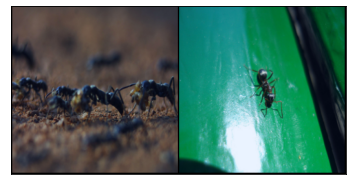

In [42]:
x = next(iter(dataloaders["train"]))
grid = torchvision.utils.make_grid(x[0], normalize=True)
show(grid)

# Principal aspects when distilling
* Model selection
  * Teacher
  * Student: Weight initialization
* Loss function definition
* Train-Val loop module

## Model selection

### Teacher

In [54]:
# Load restnet 50
teacher_model = torch.load("../models/resnet50_bees.pt", map_location=torch.device('cpu'))

### Student

In [55]:
# Load restnet 18
# Weight initialization using imagenet pretrained weights
student_model = models.resnet18(pretrained=True)

In [ ]:
# Freeze unused layers
for param in student_model.parameters():
        param.requires_grad = False


num_ftrs = student_model.fc.in_features

# Sets linear outputs
student_model.fc = torch.nn.Linear(num_ftrs, 2)

In [51]:

def trainable_params(model):
    trainable_total_params = sum(
            p.numel() for p in model.parameters() if p.requires_grad
        )
    notrainable_total_params = sum(
            p.numel() for p in model.parameters() if not p.requires_grad
        )

    print(
        f"Number no trainable parameters: {notrainable_total_params} \nNumber trainable parameters: {trainable_total_params}"
    )

for model in [teacher_model, student_model]:
    print("-"*25)
    trainable_params(model)
print("-"*25)

-------------------------
Number no trainable parameters: 0 
Number trainable parameters: 23512130
-------------------------
Number no trainable parameters: 11176512 
Number trainable parameters: 1026
-------------------------


## Loss function definition

![image](../img/equation1.png)

In [46]:
def distilation_loss_fn(y_pred_teacher, y_pred_student, y_true, alpha):
    mse_loss_fn, cross_entropy_loss_fn = torch.nn.MSELoss(), torch.nn.CrossEntropyLoss()
    mse_loss = mse_loss_fn(y_pred_teacher, y_pred_student)
    cross_entropy_loss = cross_entropy_loss_fn(y_pred_student, y_true)
    return (1 - alpha) * mse_loss + alpha * cross_entropy_loss

## Train-Val module

In [52]:
class ModelDistilation(pl.LightningModule):
    def __init__(self, teacher, student, alpha, loss_fn=distilation_loss_fn) -> None:
        super().__init__()
        self. teacher = teacher
        self.student = student
        self.alpha = alpha
        self.loss_fn = loss_fn
        train_acc = torchmetrics.Accuracy()
        val_acc = torchmetrics.Accuracy()
        self.metrics = {
            "train": {
                "acc": train_acc
            },
            "val": {
                "acc": val_acc
            }
        }

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student.parameters(), lr=1e-3)
        return optimizer

    def forward(self, batch, mode: str) -> torch.Tensor:
        metrics = self.metrics[mode]
        x, y_true = batch
        y_predict_student = self.student(x)
        y_predict_teacher = self.teacher(x)

        # compute metrics
        acc = metrics["acc"](y_predict_student, y_true)
        loggits_diff = torch.abs(y_predict_teacher - y_predict_student).mean()
        loss = self.loss_fn(y_predict_teacher, y_predict_student, y_true, self.alpha)

        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log(f"{mode}_loggits_diff", loggits_diff, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log(f"{mode}_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        loss = self.forward(train_batch, mode="train")
        return loss
    
    def validation_step(self, val_batch, batch_idx) -> torch.Tensor:
        loss = self.forward(val_batch, mode="val")
        return loss


In [53]:
# Sets logs configuration
logger = TensorBoardLogger(f"{LOGS_FOLDER_DIR}", name=MODEL_NAME)
model = ModelDistilation(teacher=teacher_model, student=student_model, alpha=0.5)

checkpoint_callback = ModelCheckpoint(
        save_top_k=10,
        monitor="val_loss",
        mode="min",
        dirpath=f"{MODEL_CHECKPOINT_DIR}/{MODEL_NAME}",
        filename="maderapp-{epoch:02d}-{val_loss:.2f}",
    )

device = "cuda" if torch.cuda.is_available() else "cpu"

# Train model
trainer = pl.Trainer(
    accelerator=device,
    gpus=torch.cuda.device_count(),
    max_epochs=4,
    check_val_every_n_epoch=2,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model=model, train_dataloaders=dataloaders["train"], val_dataloaders=dataloaders["val"])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name    | Type   | Params
-----------------------------------
0 | teacher | ResNet | 23.5 M
1 | student | ResNet | 11.2 M
-----------------------------------
23.5 M    Trainable params
11.2 M    Non-trainable params
34.7 M    Total params
138.759   Total estimated model params size (MB)
/opt/anaconda3/envs/pt-lightnin/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/anvelezec/Documents/self_studing/distillation/distillation/checkpoint/restNet exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/anaconda3/envs/pt-lightnin/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/anaconda3/envs/pt-lightnin/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/opt/anaconda3/envs/pt-lightnin/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 3: 100%|██████████| 199/199 [11:25<00:00,  3.44s/it, loss=0.435, v_num=2, train_acc=0.779, train_loggits_diff=0.556, train_loss=0.484, val_acc=0.941, val_loggits_diff=1.000, val_loss=0.970]
